In [1]:
!pip install umap-learn
!pip install hdbscan
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 21.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached Cython-0.29.37-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.manylinux_2_24_x86_64.whl (1.9 MB)
  Created wheel for hdbscan: filename=hdbscan-0.8.33-cp310-cp310-linux_x86_64.whl size=3039277 sha256=637ee5e0c9879a761daf635f271b293124a3b86c54f1ea4c91452c510da58414
  Stored in directory: /root/.cache/pip/wheels/75/0b/3b/dc4f60b7cc455efaefb62883a7483e76f09d06ca81cf87d610
Successfully built hdbscan
  Attempting uninstall: cython
    Found existing installation: Cython 3.0.10
    Uninstalling Cython-3.0.10:
      Successfully uninstalled Cython-3.0.10
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.

In [2]:
!pip install datasets

In [3]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud

import pandas as pd
import numpy as np

from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.cluster import KMeans, DBSCAN, SpectralClustering
import hdbscan

import torch.nn.functional as F
import torch

from torch import Tensor
from transformers import AutoTokenizer, AutoModel
from datasets import load_dataset, Dataset
from torch.utils.data import DataLoader, TensorDataset

from tqdm import tqdm

import umap

from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [4]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [5]:
table_path = "/content/full_processed_dataset.csv"
data = pd.read_csv(table_path)
data.dropna(axis=0, how='any', inplace=True)
data.parsed_text = data.parsed_text.astype(str)

data.head()

,url,base_category_nm,parsed_text
0,https://aspect-school.ru,Образование,курс маникюр школа обучение ученик мастер ногт...
1,https://rlagency.ru,Развлечения,билет купить руб подробный любовь дк павлово с...
2,https://kozlovatravel.u-on.ru,Развлечения,Автоматизированная система U ON Travel Забыли ...
3,https://rootsyou.tilda.ws,Красота,крем мыло баттеры аромароллер косметика душа п...
4,https://esk.one/p/wadgpcigy2vveo,Образование,прототип блок схема поддержка mind esk one сер...


In [6]:
lol = []
for i in range(data.shape[0]):
    if data.loc[i, 'parsed_text'].find('Страница входа Восстановить Зарегистрироваться') != -1:
        lol.append(i)
print(lol)

[87, 133, 230, 568, 785, 795, 1075, 1216, 1361, 1365, 1638, 1658, 1953, 2061, 2301, 2360, 2519, 2696, 3162, 3186, 3236, 3376, 4330, 4577, 4680, 4882, 4923, 5079, 5173, 5225, 5266, 5303, 5626, 5694, 5740, 5994, 6067, 6232, 6233, 6513, 7210, 7651, 8013, 8041, 8059, 8097, 8101, 8434, 8509, 8552, 8902, 8934, 9094, 9133, 9184, 9369, 9453, 9464, 9575, 9621, 9775, 9864, 9865, 10375, 10425, 10538, 10663, 10711, 10768, 10857, 10868, 11489, 11538, 11568, 11701, 11784, 11919, 12251, 12295, 12320, 12511, 12554, 12644, 12837, 13174, 13203, 13378, 14085, 14376, 14405, 14552, 14719, 15068, 15206, 15251, 15270, 15815, 15959, 15994, 16377, 16435, 16849, 16947, 16999, 17426, 17707, 17779, 17808, 18204, 18273, 18602, 18758, 18821, 18994, 19279, 19609, 19975, 20083, 20227, 20418, 20435, 20563, 20685, 20802, 21165, 21229, 21464, 21499, 21527, 21532, 21586, 21646, 21903, 22078, 22088, 22259, 22965, 22974, 23037, 23105, 23189, 23193, 23372, 23799, 23825, 23978, 24151, 24270, 24292, 24900, 24908, 25125, 25216

In [7]:
data.loc[lol, :]

,url,base_category_nm,parsed_text
87,https://lk.masha.fit,Образование,Страница входа Восстановить Зарегистрироваться...
133,https://course.kaina.ru,Образование,Страница входа Восстановить Зарегистрироваться...
230,https://kurs.speechka.online,Образование,Страница входа Восстановить Зарегистрироваться...
568,https://dociureva.com,Образование,Страница входа Восстановить Зарегистрироваться...
785,https://kurs.smolyaninovablog.ru,Образование,Страница входа Восстановить Зарегистрироваться...
...,...,...,...
36386,https://turkeeva.ru,Образование,Страница входа Восстановить Зарегистрироваться...
36687,https://kidspravo.ru,Цифровые услуги,Страница входа Восстановить Зарегистрироваться...
36701,https://tatiananovinskaya.ru,Образование,Страница входа Восстановить Зарегистрироваться...
36935,https://larina-m.ru,Образование,Страница входа Восстановить Зарегистрироваться...


In [8]:
data.drop(index=lol, inplace=True)

In [9]:
data['base_category_nm'].unique()

array(['Образование', 'Развлечения', 'Красота',
       'Продажа различных товаров', 'Авиабилеты', 'Одежда',
       'Дом и ремонт', 'Одежда и аксессуары', 'Связь и телеком',
       'Медицина', 'Салоны красоты и здоровья',
       'Электроника и бытовая техника', 'Различные услуги',
       'Подарки и сувениры', 'Цифровые услуги',
       'Заведения общественного питания', 'Автозапчасти и автосервисы',
       'Спорт', 'Зоомагазины и ветеринарные клиники', 'Транспорт',
       'Продукты', 'Рукоделие и творчество',
       'Адвокаты и юридические услуги', 'Ювелирные изделия и часы',
       'Книги и канцтовары', 'Отели', 'Печать и сканирование',
       'Танцевальные залы, школы и студии', 'Финансовые услуги', 'Цветы',
       'Магазины игрушек и хобби-товаров', 'Ремонт компьютеров',
       'Жилищно-коммунальные услуги', 'Аптеки', 'Спорттовары',
       'Курьерские услуги', 'Фотостудии', 'Оптика', 'Топливо',
       'Химчистка', 'Ателье и ремонт одежды', 'Ломбарды',
       'Клубы видеоигр', 'Бары, п

In [10]:
def draw_wordcloud(texts, max_words=1000, width=1000, height=500):
    wordcloud = WordCloud(background_color='white', max_words=max_words,
                          width=width, height=height)

    joint_texts = ' '.join(list(texts))
    wordcloud.generate(joint_texts)
    return wordcloud.to_image()

In [11]:
tokenizer = AutoTokenizer.from_pretrained('intfloat/multilingual-e5-large')
model = AutoModel.from_pretrained('intfloat/multilingual-e5-large').to(device)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/418 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/280 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/690 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.24G [00:00<?, ?B/s]

In [12]:
data['text'] = data['parsed_text'].apply(lambda x: "query: " + x)
data.head()

,url,base_category_nm,parsed_text,text
0,https://aspect-school.ru,Образование,курс маникюр школа обучение ученик мастер ногт...,query: курс маникюр школа обучение ученик маст...
1,https://rlagency.ru,Развлечения,билет купить руб подробный любовь дк павлово с...,query: билет купить руб подробный любовь дк па...
2,https://kozlovatravel.u-on.ru,Развлечения,Автоматизированная система U ON Travel Забыли ...,query: Автоматизированная система U ON Travel ...
3,https://rootsyou.tilda.ws,Красота,крем мыло баттеры аромароллер косметика душа п...,query: крем мыло баттеры аромароллер косметика...
4,https://esk.one/p/wadgpcigy2vveo,Образование,прототип блок схема поддержка mind esk one сер...,query: прототип блок схема поддержка mind esk ...


In [13]:
dataset = Dataset.from_pandas(data[data["base_category_nm"] == 'Образование'])

In [14]:
%%time

TEST_SIZE = 0.3
SPLIT_RANDOM_SEED = 42
MAX_LENGTH = 512

# batch_dict = dataset.map(encode, batched=True, remove_columns="text")
batch_dict = tokenizer(dataset["text"], max_length=512, padding=True, truncation=True, return_tensors='pt')

trans_dataset = TensorDataset(batch_dict['input_ids'], batch_dict['attention_mask'])

CPU times: user 5.69 s, sys: 447 ms, total: 6.13 s
Wall time: 5.55 s


In [15]:
batch_size = 1
data_loader = DataLoader(trans_dataset, batch_size=batch_size, shuffle=False)

In [16]:
%%time

def average_pool(last_hidden_states: Tensor, attention_mask: Tensor) -> Tensor:
    last_hidden = last_hidden_states.masked_fill(~attention_mask[..., None].bool(), 0.0)
    return last_hidden.sum(dim=1) / attention_mask.sum(dim=1)[..., None]

model.eval()
result = None
for input_ids, attention_mask in tqdm(data_loader, desc=f'Trans'):
    input_ids = input_ids.to(device)
    attention_mask = attention_mask.to(device)

    out = model(input_ids, attention_mask=attention_mask)
    embeddings = average_pool(out.last_hidden_state, attention_mask)

    res = embeddings.cpu().detach().numpy().astype("float")
    if result is None:
        result = res.copy()
    else:
        result = np.append(result, res, axis=0)

Trans: 100%|██████████| 8364/8364 [11:31<00:00, 12.10it/s]

CPU times: user 10min 27s, sys: 51.7 s, total: 11min 19s
Wall time: 11min 31s


In [17]:
result.shape

(8364, 1024)

In [18]:
import gc
torch.cuda.empty_cache()
gc.collect()

0

In [19]:
data['ЕГЭ'] = data['text'].apply(lambda x: (x.find('ЕГЭ') != -1) or (x.find('егэ') != -1))
new_data = data[data["base_category_nm"] == 'Образование']

In [20]:
kmeans = KMeans(n_clusters=4).fit(result)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [25]:
scaled_penguin_data = StandardScaler().fit_transform(result)

In [26]:
%%time

reducer = umap.UMAP()
embedding = reducer.fit_transform(scaled_penguin_data)
embedding.shape

CPU times: user 47.1 s, sys: 628 ms, total: 47.7 s
Wall time: 43.7 s


(8364, 2)

In [27]:
hdbscan_model = hdbscan.HDBSCAN(cluster_selection_epsilon=5).fit(result)

In [38]:
colors = ['#000000', '#ff0000', '#00ff00', '#0000ff', '#ff9900', '#99cc00',
'#cc00cc', '#ffcc00', '#33ccff', '#009900', '#cc99cc', '#ff3300',
'#66ffcc', '#99ffcc', '#ffcc99', '#ff9999', '#cccccc', '#993366',
'#ffcc66', '#669999', '#ff6600', '#6633ff', '#9966ff', '#6699cc',
'#339933']

## Selecting min_cluster_size

Counter({-1: 5397, 1: 2933, 2: 17, 0: 17})
[1, -1]


<ipython-input-28-5ee1b316e4ae>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_data['cluster'] = clusterer.labels_
<ipython-input-28-5ee1b316e4ae>:19: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(


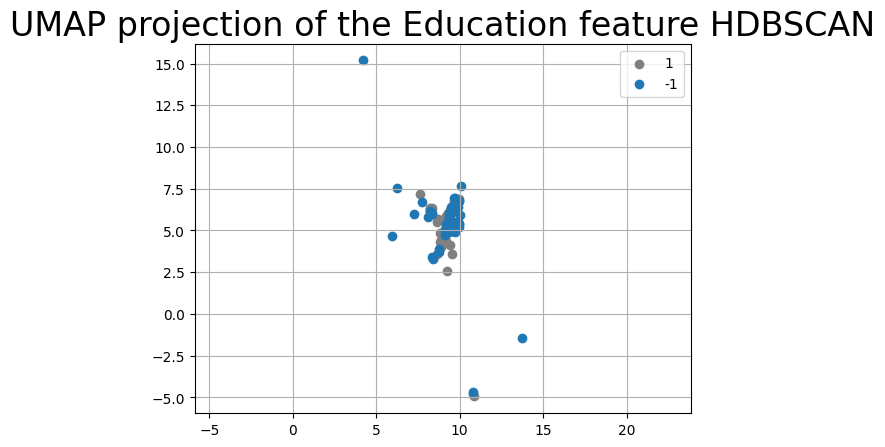

In [28]:
# 15 - ок
from collections import Counter


clusterer = hdbscan.HDBSCAN(min_cluster_size=15).fit(result)
lol = Counter(clusterer.labels_)
print(lol)

new_data['cluster'] = clusterer.labels_
indexes = list(new_data[new_data['ЕГЭ'] == True]['cluster'].value_counts().index)
print(indexes)

fig, ax = plt.subplots()
for lbl in indexes:
    ax.scatter(
        embedding[(new_data['ЕГЭ'] == True) & (new_data['cluster'] == lbl)][:, 0],
        embedding[(new_data['ЕГЭ'] == True) & (new_data['cluster'] == lbl)][:, 1],
        c=sns.color_palette()[lbl],
        label=lbl)

ax.legend()
ax.grid(True)

plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection of the Education feature HDBSCAN', fontsize=24)

plt.show()

Counter({-1: 7502, 0: 764, 1: 98})
[-1, 0, 1]


<ipython-input-40-46cb46a43cfe>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_data['cluster'] = clusterer.labels_
<ipython-input-40-46cb46a43cfe>:16: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(


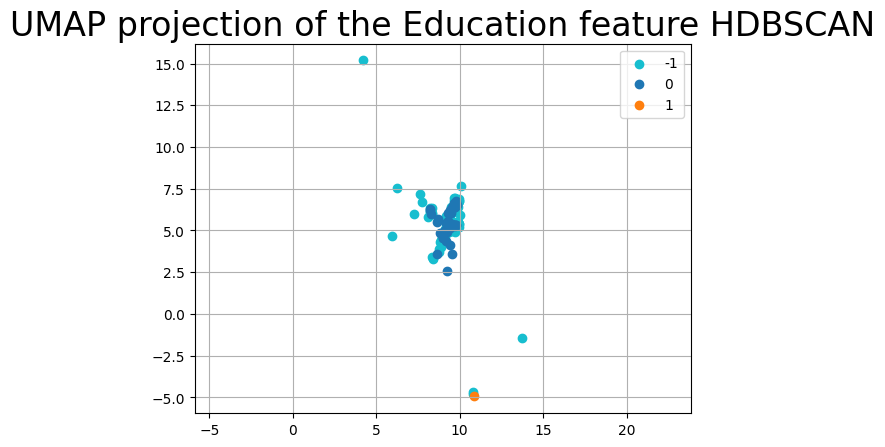

In [40]:
# 30 - перебор, всё смешалось как будто
from collections import Counter


clusterer = hdbscan.HDBSCAN(min_cluster_size=30).fit(result)
lol = Counter(clusterer.labels_)
print(lol)


new_data['cluster'] = clusterer.labels_
indexes = list(new_data[new_data['ЕГЭ'] == True]['cluster'].value_counts().index)
print(indexes)

fig, ax = plt.subplots()
for lbl in indexes:
    ax.scatter(
        embedding[(new_data['ЕГЭ'] == True) & (new_data['cluster'] == lbl)][:, 0],
        embedding[(new_data['ЕГЭ'] == True) & (new_data['cluster'] == lbl)][:, 1],
        c=sns.color_palette()[lbl],
        label=lbl)

ax.legend()
ax.grid(True)

plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection of the Education feature HDBSCAN', fontsize=24)

plt.show()

Counter({-1: 6704, 19: 1349, 20: 129, 16: 19, 1: 18, 8: 17, 7: 12, 9: 12, 2: 11, 6: 10, 17: 9, 10: 9, 11: 9, 18: 8, 5: 8, 3: 6, 14: 6, 4: 6, 13: 6, 0: 6, 15: 5, 12: 5})
[-1, 19, 20, 6]


<ipython-input-39-881a2c0bd382>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_data['cluster'] = clusterer.labels_


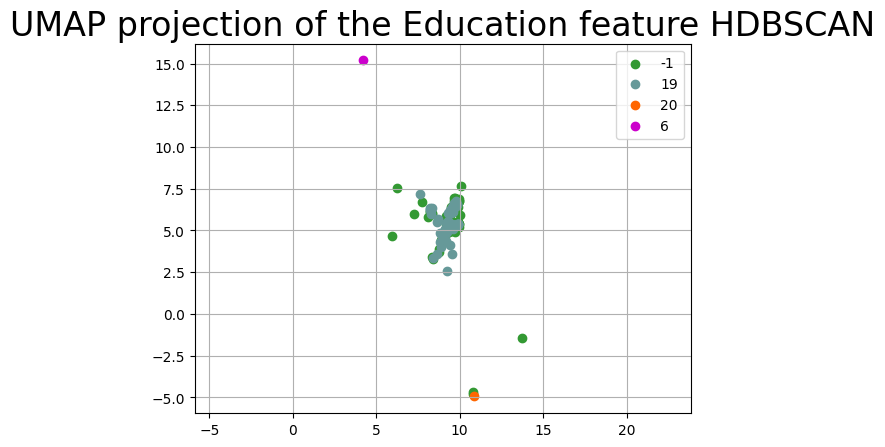

In [39]:
# 5 - ок, чуть получше, чем 15
from collections import Counter


clusterer = hdbscan.HDBSCAN(min_cluster_size=5).fit(result)
lol = Counter(clusterer.labels_)
print(lol)


new_data['cluster'] = clusterer.labels_
indexes = list(new_data[new_data['ЕГЭ'] == True]['cluster'].value_counts().index)
print(indexes)

fig, ax = plt.subplots()
for lbl in indexes:
    ax.scatter(
        embedding[(new_data['ЕГЭ'] == True) & (new_data['cluster'] == lbl)][:, 0],
        embedding[(new_data['ЕГЭ'] == True) & (new_data['cluster'] == lbl)][:, 1],
        c=colors[lbl],
        label=lbl)

ax.legend()
ax.grid(True)

plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection of the Education feature HDBSCAN', fontsize=24)

plt.show()

Counter({-1: 4991, 3: 3316, 4: 17, 0: 17, 2: 12, 1: 11})
[3, -1]


<ipython-input-41-4c06168f7d24>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_data['cluster'] = clusterer.labels_


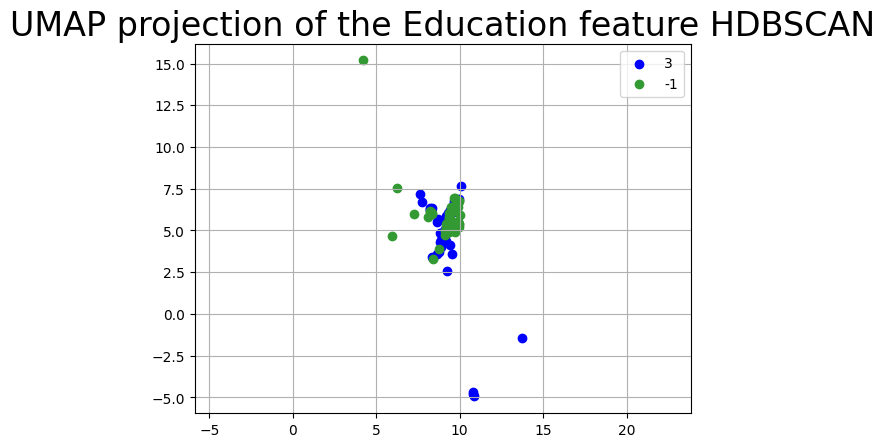

In [41]:
# 10 - ровно как 15
from collections import Counter


clusterer = hdbscan.HDBSCAN(min_cluster_size=10).fit(result)
lol = Counter(clusterer.labels_)
print(lol)


new_data['cluster'] = clusterer.labels_
indexes = list(new_data[new_data['ЕГЭ'] == True]['cluster'].value_counts().index)
print(indexes)

fig, ax = plt.subplots()
for lbl in indexes:
    ax.scatter(
        embedding[(new_data['ЕГЭ'] == True) & (new_data['cluster'] == lbl)][:, 0],
        embedding[(new_data['ЕГЭ'] == True) & (new_data['cluster'] == lbl)][:, 1],
        c=colors[lbl],
        label=lbl)

ax.legend()
ax.grid(True)

plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection of the Education feature HDBSCAN', fontsize=24)

plt.show()

Counter({-1: 4713, 4: 3584, 5: 17, 0: 17, 3: 12, 1: 11, 2: 10})
[4, -1, 2]


<ipython-input-42-e7b383f91ab0>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_data['cluster'] = clusterer.labels_


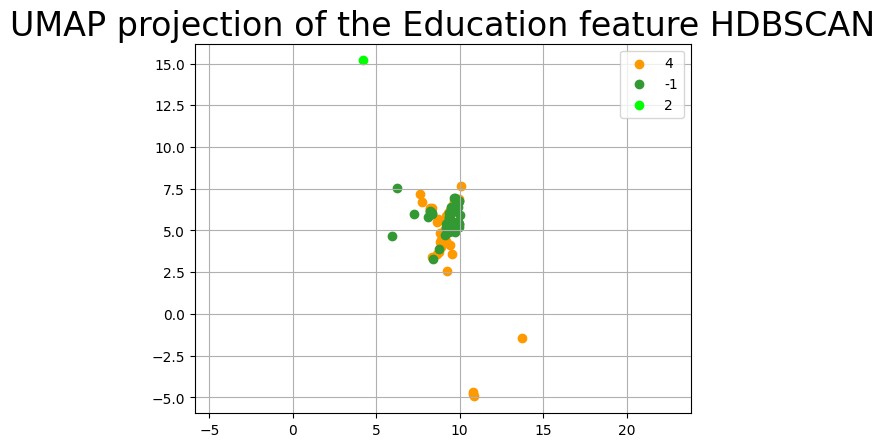

In [42]:
# 7 - кажется, репрезентативнее всех
from collections import Counter


clusterer = hdbscan.HDBSCAN(min_cluster_size=7).fit(result)
color_palette = sns.color_palette('Paired', len(clusterer.labels_))
cluster_colors = [color_palette[x] if x >= 0
                  else (0.5, 0.5, 0.5)
                  for x in clusterer.labels_]
lol = Counter(clusterer.labels_)
print(lol)


new_data['cluster'] = clusterer.labels_
indexes = list(new_data[new_data['ЕГЭ'] == True]['cluster'].value_counts().index)
print(indexes)

fig, ax = plt.subplots()
for lbl in indexes:
    ax.scatter(
        embedding[(new_data['ЕГЭ'] == True) & (new_data['cluster'] == lbl)][:, 0],
        embedding[(new_data['ЕГЭ'] == True) & (new_data['cluster'] == lbl)][:, 1],
        c=colors[lbl],
        label=lbl)

ax.legend()
ax.grid(True)

plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection of the Education feature HDBSCAN', fontsize=24)

plt.show()

In [37]:
print(len(sns.color_palette()))

10


пупипуппипу


## Selecting min_samples

Фиксируем min_cluster_size=7 и смотрим на число семплов. (The number of samples in a neighborhood for a point to be considered as a core point. This includes the point itself. When None, defaults to min_cluster_size.)

Counter({-1: 4467, 1: 3862, 0: 18, 2: 17})
[1, -1]


<ipython-input-43-e361734571ca>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_data['cluster'] = clusterer.labels_


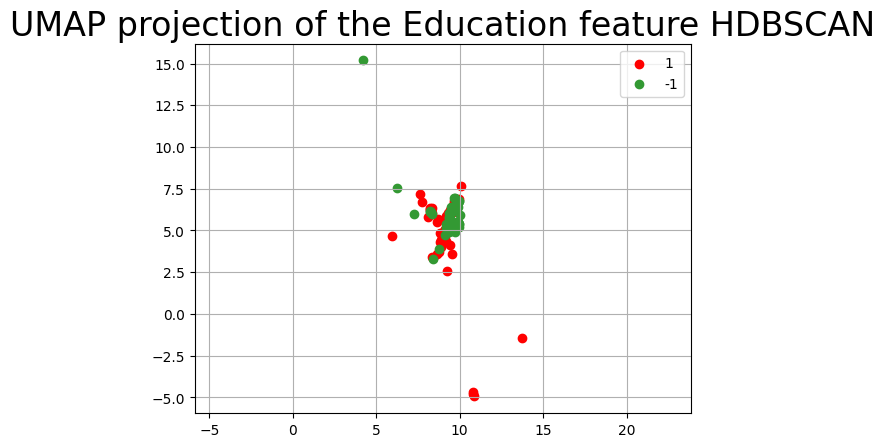

In [43]:
# 5 - окэй
from collections import Counter


clusterer = hdbscan.HDBSCAN(min_cluster_size=15, min_samples=5).fit(result)
lol = Counter(clusterer.labels_)
print(lol)


new_data['cluster'] = clusterer.labels_
indexes = list(new_data[new_data['ЕГЭ'] == True]['cluster'].value_counts().index)
print(indexes)

fig, ax = plt.subplots()
for lbl in indexes:
    ax.scatter(
        embedding[(new_data['ЕГЭ'] == True) & (new_data['cluster'] == lbl)][:, 0],
        embedding[(new_data['ЕГЭ'] == True) & (new_data['cluster'] == lbl)][:, 1],
        c=colors[lbl],
        label=lbl)

ax.legend()
ax.grid(True)

plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection of the Education feature HDBSCAN', fontsize=24)

plt.show()

Counter({1: 4990, -1: 3339, 0: 18, 2: 17})
[1, -1]


<ipython-input-44-a1a20743e939>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_data['cluster'] = clusterer.labels_


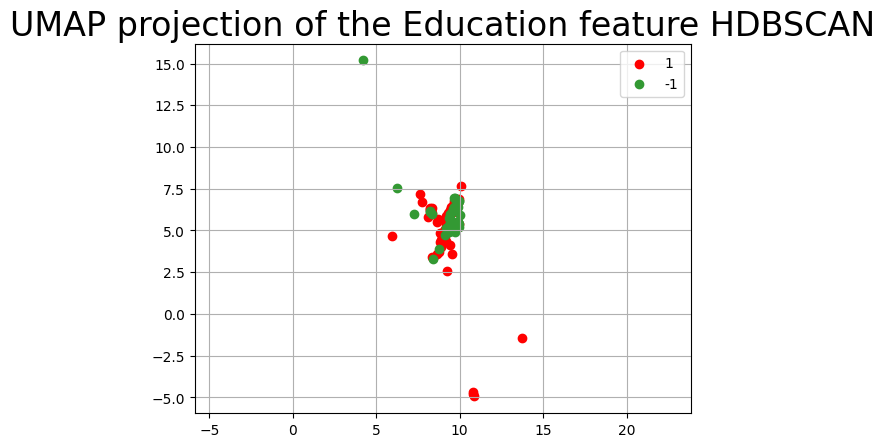

In [44]:
# 1 - никакой разницы
from collections import Counter


clusterer = hdbscan.HDBSCAN(min_cluster_size=15, min_samples=1).fit(result)
lol = Counter(clusterer.labels_)
print(lol)


new_data['cluster'] = clusterer.labels_
indexes = list(new_data[new_data['ЕГЭ'] == True]['cluster'].value_counts().index)
print(indexes)

fig, ax = plt.subplots()
for lbl in indexes:
    ax.scatter(
        embedding[(new_data['ЕГЭ'] == True) & (new_data['cluster'] == lbl)][:, 0],
        embedding[(new_data['ЕГЭ'] == True) & (new_data['cluster'] == lbl)][:, 1],
        c=colors[lbl],
        label=lbl)

ax.legend()
ax.grid(True)

plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection of the Education feature HDBSCAN', fontsize=24)

plt.show()

Мы не увидели каких-то значимых изменений тк кластеров маловато в данном случае. В перспективе это может сказаться на объемах отдельных кластеров. Оставим этот параметр = 5

Counter({8: 4990, -1: 3269, 0: 18, 9: 17, 5: 12, 7: 11, 1: 11, 4: 10, 3: 10, 6: 9, 2: 7})
[8, -1, 4]


<ipython-input-48-1b7da6764ef0>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_data['cluster'] = clusterer.labels_


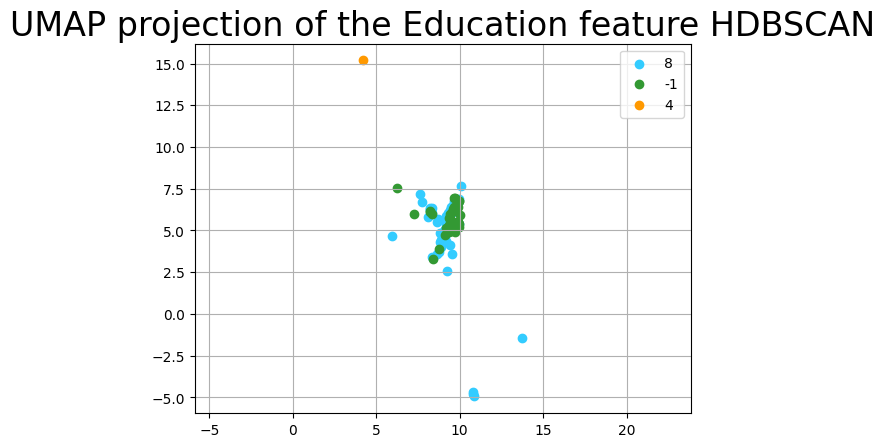

In [48]:
# 1, но min cluster = 7 - ничего не изменилось особо
from collections import Counter


clusterer = hdbscan.HDBSCAN(min_cluster_size=7, min_samples=1).fit(result)
lol = Counter(clusterer.labels_)
print(lol)


new_data['cluster'] = clusterer.labels_
indexes = list(new_data[new_data['ЕГЭ'] == True]['cluster'].value_counts().index)
print(indexes)

fig, ax = plt.subplots()
for lbl in indexes:
    ax.scatter(
        embedding[(new_data['ЕГЭ'] == True) & (new_data['cluster'] == lbl)][:, 0],
        embedding[(new_data['ЕГЭ'] == True) & (new_data['cluster'] == lbl)][:, 1],
        c=colors[lbl],
        label=lbl)

ax.legend()
ax.grid(True)

plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection of the Education feature HDBSCAN', fontsize=24)

plt.show()

## Selecting alpha

By default alpha is set to 1.0. Increasing alpha will make the clustering more conservative, but on a much tighter scale

Counter({-1: 8192, 3: 74, 2: 46, 1: 18, 4: 17, 0: 17})
[-1]


<ipython-input-45-8b9e8cb7ece4>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_data['cluster'] = clusterer.labels_


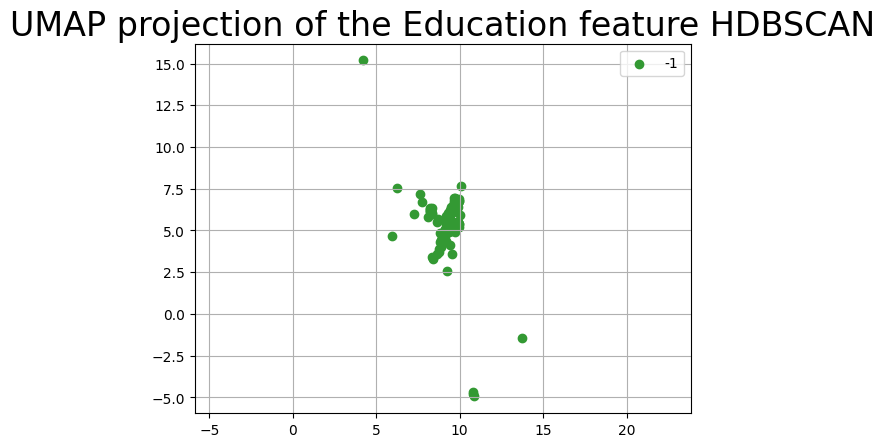

In [45]:
# 1,5 - убили и те два кластера что были, больше точно брать не надо
from collections import Counter


clusterer = hdbscan.HDBSCAN(min_cluster_size=15, min_samples=5, alpha=1.5).fit(result)
lol = Counter(clusterer.labels_)
print(lol)


new_data['cluster'] = clusterer.labels_
indexes = list(new_data[new_data['ЕГЭ'] == True]['cluster'].value_counts().index)
print(indexes)

fig, ax = plt.subplots()
for lbl in indexes:
    ax.scatter(
        embedding[(new_data['ЕГЭ'] == True) & (new_data['cluster'] == lbl)][:, 0],
        embedding[(new_data['ЕГЭ'] == True) & (new_data['cluster'] == lbl)][:, 1],
        c=colors[lbl],
        label=lbl)

ax.legend()
ax.grid(True)

plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection of the Education feature HDBSCAN', fontsize=24)

plt.show()

Counter({-1: 7693, 3: 527, 2: 92, 4: 18, 1: 17, 0: 17})
[-1, 3, 2]


<ipython-input-46-d24c0817aaaf>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_data['cluster'] = clusterer.labels_


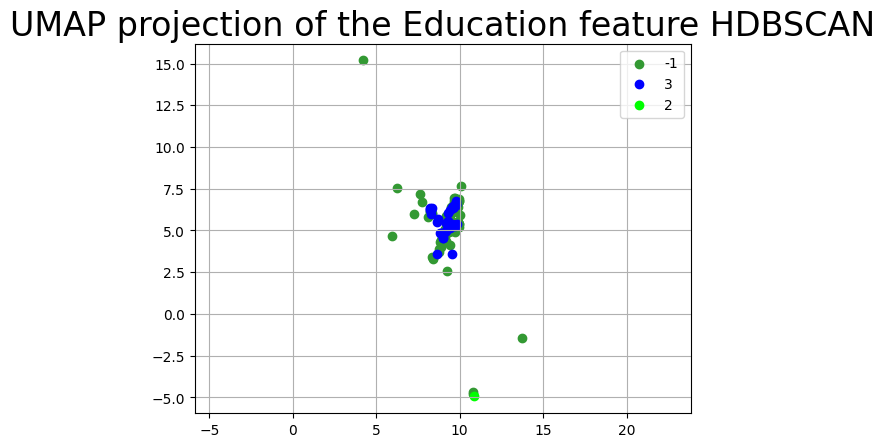

In [46]:
# 1,2 - зашибато вполне, выделили какую-то крошку точку
from collections import Counter


clusterer = hdbscan.HDBSCAN(min_cluster_size=15, min_samples=5, alpha=1.2).fit(result)
lol = Counter(clusterer.labels_)
print(lol)


new_data['cluster'] = clusterer.labels_
indexes = list(new_data[new_data['ЕГЭ'] == True]['cluster'].value_counts().index)
print(indexes)

fig, ax = plt.subplots()
for lbl in indexes:
    ax.scatter(
        embedding[(new_data['ЕГЭ'] == True) & (new_data['cluster'] == lbl)][:, 0],
        embedding[(new_data['ЕГЭ'] == True) & (new_data['cluster'] == lbl)][:, 1],
        c=colors[lbl],
        label=lbl)

ax.legend()
ax.grid(True)

plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection of the Education feature HDBSCAN', fontsize=24)

plt.show()

Counter({-1: 6924, 10: 1309, 9: 20, 6: 17, 0: 17, 4: 12, 8: 12, 1: 11, 3: 10, 2: 9, 7: 9, 5: 7, 11: 7})
[-1, 10, 3]


<ipython-input-49-a1c1cec5b090>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_data['cluster'] = clusterer.labels_


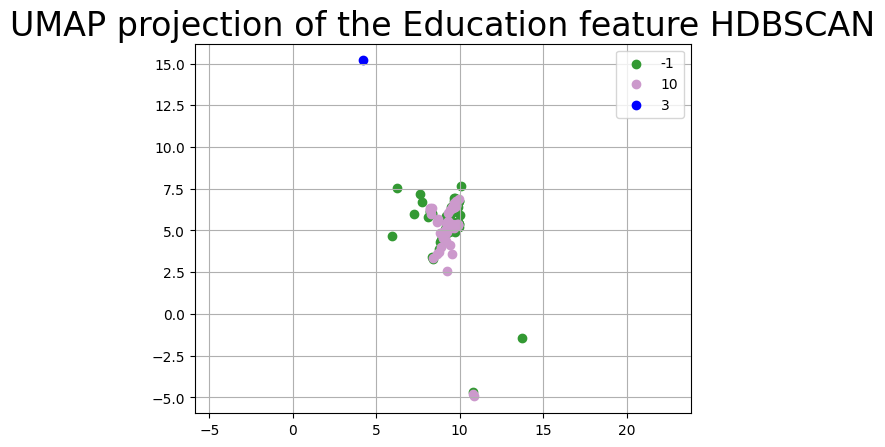

In [49]:
# 1,2 но с другими двумя гиперпараметрами - никаких значительных изменений
from collections import Counter


clusterer = hdbscan.HDBSCAN(min_cluster_size=7, min_samples=1, alpha=1.2).fit(result)
lol = Counter(clusterer.labels_)
print(lol)


new_data['cluster'] = clusterer.labels_
indexes = list(new_data[new_data['ЕГЭ'] == True]['cluster'].value_counts().index)
print(indexes)

fig, ax = plt.subplots()
for lbl in indexes:
    ax.scatter(
        embedding[(new_data['ЕГЭ'] == True) & (new_data['cluster'] == lbl)][:, 0],
        embedding[(new_data['ЕГЭ'] == True) & (new_data['cluster'] == lbl)][:, 1],
        c=colors[lbl],
        label=lbl)

ax.legend()
ax.grid(True)

plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection of the Education feature HDBSCAN', fontsize=24)

plt.show()

В целом немного можно изменить структуру кластеров, но незначительно. Будет больше кластеров - будет заметнее.